In [ ]:
# Import libraries.
import io 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
import copy

# Google colab modules.
from google.colab import files

# Sklearn modules.
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from datetime import datetime

# PyTorch libraries and modules.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
import csv
import os





In [ ]:
# Check device.
# torch.cuda.get_device_name(0)

# COVID-19 Data Preprocessing.

In [ ]:
# Upload COVID training data.
covid_train = files.upload()

# Upload COVID test data.
covid_test = files.upload()

# Read COVID-19 datasets as pandas dataframes.
covid_train_df = pd.read_csv(io.BytesIO(covid_train['covid_train.csv']))
covid_test_df = pd.read_csv(io.BytesIO(covid_test['covid_test.csv']))


Saving covid_train.csv to covid_train.csv


Saving covid_test.csv to covid_test.csv


In [ ]:
def process_covid_data(covid_df):
  '''
  Function for processing COVID-19 data.
  '''
  def date_to_iso(date):
    try:
      return datetime.fromisoformat(date).timestamp()
    except:
      return 0

  def age_to_ordinal(age_str):
    if ('<' in age_str):
      return 15
    else:
      return float( age_str.replace('s','') ) + 5

  x = covid_df.drop(columns=['Outcome1'])
  y = covid_df['Outcome1']
  y_one_hot = pd.get_dummies(y, prefix='Outcome1')

  x['Outbreak_Related'].fillna('No', inplace=True)
  x['Age_Group'].fillna('80s', inplace=True)
  x['Age_Group'] = x['Age_Group'].apply(age_to_ordinal)
  x['Test_Reported_Date'] = x['Test_Reported_Date'].apply(date_to_iso)
  x['Case_Reported_Date'] = x['Case_Reported_Date'].apply(date_to_iso)
  x['Accurate_Episode_Date'] = x['Accurate_Episode_Date'].apply(date_to_iso)
  x['Specimen_Date'] = x['Specimen_Date'].apply(date_to_iso)
  
  one_hot_dfs = []
  covid_categorical = x[['Client_Gender', 'Case_AcquisitionInfo', 'Reporting_PHU_City', 'Outbreak_Related']]
  
  for col in covid_categorical:
    one_hot_df = pd.get_dummies(covid_categorical[col], prefix=col)
    one_hot_dfs.append(one_hot_df)
  
  concat_one_hot_dfs = pd.concat(one_hot_dfs, axis=1)

  
  numerical = ['id', 'Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date', 'Age_Group', 'Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
  df = pd.concat([x[numerical], concat_one_hot_dfs, y_one_hot], axis=1)
  
  df_test = df[(df['Outcome1_Fatal']==0) & (df['Outcome1_Not Resolved']==0) & (df['Outcome1_Resolved']==0)]
  df_test = df_test.drop(columns=['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'])
  df_train = df[(df['Outcome1_Fatal']!=0) | (df['Outcome1_Not Resolved']!=0) | (df['Outcome1_Resolved']!=0)]
  df_train = df_train.drop(columns=['id'])                                
  # df_test = df[df[['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved']].any() == False]
  # df_train = df[df[['Outcome1_Fatal', 'Outcome1_Not', 'Outcome1_Resolved']].any()]

  x_df = df_train.drop(columns=['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'])
  y_df = df_train[['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved']]
  cov_train_x, cov_test_x, cov_train_y, cov_test_y = train_test_split(x_df, 
                                                                      y_df, 
                                                                      test_size=0.2, 
                                                                      random_state=275)
  
  return cov_train_x, cov_test_x, cov_train_y, cov_test_y, df_test, x_df, y_df

covid_df = pd.concat([covid_train_df, covid_test_df])
covid_train_x, covid_test_x, covid_train_y, covid_test_y, kaggle_df, full_train_x, full_train_y = process_covid_data(covid_df)
print(covid_train_y.columns)

Index(['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'], dtype='object')


In [ ]:
def save_nets(nets):
  for (i, net_i) in enumerate(nets):
    with open('/content/drive/MyDrive/ECE657A/A4_covid_nets/' + str(i+1), 'w') as f:      
      write = csv.writer(f)
      write.writerow(['train_loss', 'train_acc', 'val_loss', 'val_acc'])
      for j in range(len(net_i[0])):
        write.writerow([net_i[0][j], net_i[1][j], net_i[2][j], net_i[3][j]])

def load_nets():
  ret = []
  for root,dirs,files in os.walk('/content/drive/MyDrive/ECE657A/A4_covid_nets'):
    for file in sorted(files, key=lambda x: int(x)):
      f=open('/content/drive/MyDrive/ECE657A/A4_covid_nets/' + file, 'r')
      train_losses = []
      train_accs = []
      val_losses = []
      val_accs = []
      reader = csv.reader(f, delimiter=',')
      next(reader, None)
      for row in reader:
        train_losses.append(float(row[0]))
        train_accs.append(float(row[1]))
        val_losses.append(float(row[2]))
        val_accs.append(float(row[3]))
      f.close()
      ret.append((train_losses, train_accs, val_losses, val_accs))
  return ret

class CovidDataset(Dataset):
    def __init__(self, x_df, y_df):
        self.x_ten = torch.tensor(x_df.values, dtype=torch.float)
        self.y_ten = torch.tensor(y_df.values, dtype=torch.float)

    def __len__(self):
        return self.x_ten.size()[0]

    def __getitem__(self, idx):
        return (self.x_ten[idx], self.y_ten[idx])

class CovidDatasetTemporal(Dataset):
    def __init__(self, x_df, y_df):
        df = pd.concat([x_df, y_df], axis=1)
        df.sort_values('Case_Reported_Date', inplace=True)
        x_df = df.drop(columns=['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'])
        y_df = df[['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved']]
        self.x_ten = torch.tensor(x_df.values, dtype=torch.float)
        self.y_ten = torch.tensor(y_df.values, dtype=torch.float)

    def __len__(self):
        return self.x_ten.size()[0]

    def __getitem__(self, idx):
        return (self.x_ten[idx], self.y_ten[idx])

class CovidDatasetTemporalPerPHU(Dataset):
    '''
      In this dataset, each instance is an entire input sequence per PHU
    '''
    def __init__(self, x_df, y_df):
        self.x = []
        self.y = []
        df = pd.concat([x_df, y_df], axis=1)
        phu_cols = [c for c in df.columns if 'Reporting_PHU_City' in c]
        for phu in phu_cols:
          split_df = df.loc[df[phu] > 0]
          if len(split_df) < 2:
            continue
          split_df = split_df.sort_values('Case_Reported_Date')
          split_x_df = split_df.drop(columns=['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'])
          split_y_df = split_df[['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved']]
          self.x.append(torch.tensor(split_x_df.values, dtype=torch.float))
          self.y.append(torch.tensor(split_y_df.values, dtype=torch.float))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

class CovidDatasetNoTime(Dataset):
    def __init__(self, x_df, y_df):
        self.x_ten = torch.tensor(x_df.drop(columns=['Test_Reported_Date', 'Case_Reported_Date', 'Accurate_Episode_Date', 'Specimen_Date']).values, dtype=torch.float)
        self.y_ten = torch.tensor(y_df.values, dtype=torch.float)

    def __len__(self):
        return self.x_ten.size()[0]

    def __getitem__(self, idx):
        return (self.x_ten[idx], self.y_ten[idx])

class FCNet(nn.Module):
    def __init__(self, in_dimen=53, width=200, depth=3, dropout=0.0, batch_norm_every_layer=False):
        super(FCNet, self).__init__()
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else None
        self.batch_norm_every_layer = batch_norm_every_layer
        self.norm_in = nn.BatchNorm1d(in_dimen)
        self.norm_fc = nn.BatchNorm1d(width)
        self.fcs = [nn.Linear(in_dimen, width)]
        depth -= 1
        while (depth > 0):
          self.fcs.append(nn.Linear(width, width))
          depth -= 1
        self.outfc = nn.Linear(width, 3)

    def forward(self, x):
        x = self.norm_in(x)
        for i, fc in enumerate(self.fcs):
          out = fc(x)
          if self.batch_norm_every_layer:
            out = self.norm_fc(out)
          x = F.relu(out)
          if self.dropout is not None and i < len(self.fcs) - 1:
            x = self.dropout(x)
        x = self.outfc(x)
        return F.log_softmax(x)

class ResNet(nn.Module):
    def __init__(self, in_dimen=53, width=200, depth=3, batch_norm_every_layer=False):
        super(ResNet, self).__init__()
        self.norm_in = nn.BatchNorm1d(in_dimen)
        self.norm_fc = nn.BatchNorm1d(width)
        self.batch_norm_every_layer = batch_norm_every_layer
        self.fcs = [nn.Linear(in_dimen, width)]
        depth -= 1
        while (depth > 0):
          self.fcs.append(nn.Linear(width, width))
          depth -= 1
        self.outfc = nn.Linear(width, 3)

    def forward(self, x):
        x = self.norm_in(x)
        prev_x = None
        for i, fc in enumerate(self.fcs):
          out = fc(x)
          if prev_x is not None:
            out += prev_x
          if self.batch_norm_every_layer:
            out = self.norm_fc(out)
          x = F.relu(out)
          prev_x = x
        x = self.outfc(x)
        return F.log_softmax(x)
 
class GlobalLSTMNet(nn.Module):
  def __init__(self, in_dimen=53, hidden_dimen=64, fc_width=200, fc_depth=1, lstm_stack=1):
    super(GlobalLSTMNet, self).__init__()
    self.norm_in = nn.BatchNorm1d(in_dimen)
    self.lstm = nn.LSTM(in_dimen, hidden_dimen, num_layers=lstm_stack)
    self.outfc = nn.Linear(hidden_dimen, 3)
    if fc_depth > 1:
      self.infc = nn.Linear(hidden_dimen, fc_width)
      fc_depth -= 1
      self.outfc = nn.Linear(fc_width, 3)
      fc_depth -= 1
      self.fcs = []
      while fc_depth > 0:
        self.fcs.append(nn.Linear(fc_width, fc_width))
        fc_depth -= 1
    self.hidden_state = None
    self.cell_state = None
    self.fc_depth=fc_depth

  def forward(self, x):
    x = self.norm_in(x)
    if self.hidden_state is None:
      lstm_out, (lstm_hidden, lstm_cell) = self.lstm(x.view(1, len(x), -1))
    else:
      lstm_out, (lstm_hidden, lstm_cell) = self.lstm(x.view(1, len(x), -1), (self.hidden_state, self.cell_state))
    self.hidden_state = lstm_hidden.detach()
    self.cell_state = lstm_cell.detach()
    if self.fc_depth == 1:
      tag_space = self.outfc(lstm_out.view(len(x), -1))
    elif self.fc_depth == 2:
      tag_space = F.relu(self.infc(lstm_out.view(len(x), -1)))
      tag_space = self.outfc(tag_space)
    else:
      tag_space = F.relu(self.infc(lstm_out.view(len(x), -1)))
      for fc in self.fcs:
        tag_space = F.relu(fc(tag_space))
      tag_space = self.outfc(tag_space)
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

class PHULSTMNet(nn.Module):
  def __init__(self, in_dimen=53, hidden_dimen=64, fc_width=200, lstm_stack=1):
    super(PHULSTMNet, self).__init__()
    self.norm_in = nn.BatchNorm1d(in_dimen)
    self.lstm = nn.LSTM(in_dimen, hidden_dimen, num_layers=lstm_stack)
    self.outfc = nn.Linear(hidden_dimen, 3)

  def forward(self, x):
    # x is entire input sequence for a specific PHU
    x = x[0,:,:].clone()
    xnorm = self.norm_in(x)
    lstm_out, _ = self.lstm(xnorm.view(xnorm.size()[0], 1, 53))
    tag_space = self.outfc(lstm_out.view(x.size()[0], -1))
    tag_scores = F.log_softmax(tag_space, dim=1)
    return tag_scores

def acc(net_to_test, test_loader, criterion):
  correct = 0
  loss = 0
  total = 0
  infer_time = 0
  infer_num = 0
  for data, target in test_loader:
      data, target = Variable(data), Variable(target)
      tick = time.time()
      net_out = net_to_test(data)
      infer_time += time.time() - tick
      infer_num += len(target)
      if net_out.size()[0] > target.size()[0]:
        target = target.view(target.size()[1], target.size()[2])
      pred = net_out.data.max(1)[1]
      loss += criterion(net_out, torch.max(target, 1)[1]).detach().numpy()
      correct += pred.eq(torch.max(target, 1)[1]).sum().detach().numpy()
      total += len(target)
  # print("Inference time {}".format((infer_time/infer_num)*1000))
  return (loss / total, correct / total)

def train_net(net_to_train, train_loader, val_loader, epochs=20, optimizer=None, criterion=nn.NLLLoss()):
  if optimizer is None:
    optimizer = SGD(net_to_train.parameters(), lr=0.01, momentum=0.9)
  # print('Training net: {} \nFor {} epochs'.format(net_to_train, epochs))
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  tick = time.time()
  best_model = copy.deepcopy(net_to_train)
  best_acc = 0
  for epoch in range(epochs):
    # print("Epoch time {}".format(time.time() - tick))
    tick = time.time()
    (train_loss, train_acc) = acc(net_to_train, train_loader, criterion)
    (val_loss, val_acc) = acc(net_to_train, val_loader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_acc > best_acc:
      best_model = copy.deepcopy(net_to_train)
      best_acc = val_acc
    print('Train Epoch: {}\tValidation Acc: {}'.format(epoch, val_acc))
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = Variable(data), Variable(target)
      optimizer.zero_grad()
      net_out = net_to_train(data)
      if net_out.size()[0] > target.size()[0]:
        loss = criterion(net_out, torch.max(target.view(target.size()[1], target.size()[2]), 1)[1])
      else:
        loss = criterion(net_out, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
  return (train_losses, train_accs, val_losses, val_accs, best_model)


In [ ]:
# Run to init new loaders
train_loader = DataLoader(CovidDataset(covid_train_x, covid_train_y), batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(CovidDataset(covid_test_x, covid_test_y), batch_size=4, shuffle=True, num_workers=0)
train_loader_no_time = DataLoader(CovidDatasetNoTime(covid_train_x, covid_train_y), batch_size=4, shuffle=True, num_workers=0)
test_loader_no_time = DataLoader(CovidDatasetNoTime(covid_test_x, covid_test_y), batch_size=4, shuffle=True, num_workers=0)
train_loader_sorted = DataLoader(CovidDatasetTemporal(covid_train_x, covid_train_y), batch_size=4, shuffle=True, num_workers=0)
test_loader_sorted = DataLoader(CovidDatasetTemporal(covid_test_x, covid_test_y), batch_size=4, shuffle=True, num_workers=0)
train_loader_phu = DataLoader(CovidDatasetTemporalPerPHU(covid_train_x, covid_train_y), batch_size=1, shuffle=True, num_workers=0)
test_loader_phu = DataLoader(CovidDatasetTemporalPerPHU(covid_test_x, covid_test_y), batch_size=1, shuffle=True, num_workers=0)
full_train_loader_phu = DataLoader(CovidDatasetTemporalPerPHU(full_train_x, full_train_y), batch_size=1, shuffle=True, num_workers=0)

Variants tried to dicuss in report:
*   Dataset w/ and w/out time data
*   FC net with batch norm only at input layer
* FC net with batch norm between every layer
* FC net with no batch norm and instead dropout (different factors)
* FC net with batch norm and dropout
* Residual network
* Bad LSTM w/out time ordered data
* LSTM network basic
* LSTM network with deep FC on output
* Stacked LSTM network w/ no deep output
* Stacked LSTM network w/ deep output
* LSTM where each sequence is for a specific PHU (?)



In [ ]:
EPOCHS = 500
# Default FC, no time data
# net1 = train_net(FCNet(in_dimen=49), train_loader_no_time, test_loader_no_time, epochs=EPOCHS)
# Default FC, with time data
# net2 = train_net(FCNet(), train_loader, test_loader, epochs=EPOCHS)
# FC w/ norm every layer
# net3 = train_net(FCNet(batch_norm_every_layer=True), train_loader, test_loader, epochs=EPOCHS)
# FC w/ norm only at input and high dropout
# net4 = train_net(FCNet(dropout=0.5), train_loader, test_loader, epochs=EPOCHS)
# FC w/ norm only at input and low dropout
# net5 = train_net(FCNet(dropout=0.1), train_loader, test_loader, epochs=EPOCHS)
# FC w/ norm only at every layer and high dropout
# net6 = train_net(FCNet(dropout=0.5, batch_norm_every_layer=True), train_loader, test_loader, epochs=EPOCHS)
# FC w/ norm only at every layer and low dropout
# net7 = train_net(FCNet(dropout=0.1, batch_norm_every_layer=True), train_loader, test_loader, epochs=EPOCHS)
# Deep FC w/ norm only at input
# net8 = train_net(FCNet(depth=10), train_loader, test_loader, epochs=EPOCHS)
# Deep FC w/ norm at all
# net9 = train_net(FCNet(depth=10, batch_norm_every_layer=True), train_loader, test_loader, epochs=EPOCHS)

# Shallow ResNet
# net10 = train_net(ResNet(depth=3), train_loader, test_loader, epochs=EPOCHS)
# Deep ResNet
# net11 = train_net(ResNet(depth=15), train_loader, test_loader, epochs=EPOCHS)
# Deep ResNet with norm between every layer
# net12 = train_net(ResNet(depth=15, batch_norm_every_layer=True), train_loader, test_loader, epochs=EPOCHS)

# Default LSTM w/out temporal data
# net13 = train_net(GlobalLSTMNet(), train_loader, test_loader, epochs=EPOCHS)
# Default LSTM w/ temporal data
# net14 = train_net(GlobalLSTMNet(), train_loader_sorted, test_loader_sorted, epochs=EPOCHS)
# Deep output LSTM
# net15 = train_net(GlobalLSTMNet(fc_depth=5), train_loader_sorted, test_loader_sorted, epochs=EPOCHS)
# Stacked LSTM
# net16 = train_net(GlobalLSTMNet(lstm_stack=3), train_loader_sorted, test_loader_sorted, epochs=EPOCHS)
# Stacked LSTM w/ Deep output
# net17 = train_net(GlobalLSTMNet(fc_depth=5, lstm_stack=3), train_loader_sorted, test_loader_sorted, epochs=EPOCHS)
# torch.autograd.set_detect_anomaly(False)
# net18 = train_net(PHULSTMNet(), train_loader_phu, test_loader_phu, epochs=EPOCHS)
# net19 = train_net(PHULSTMNet(lstm_stack=3), train_loader_phu, test_loader_phu, epochs=EPOCHS)
# net20 = train_net(PHULSTMNet(lstm_stack=5), train_loader_phu, test_loader_phu, epochs=EPOCHS)
kaggle_net = PHULSTMNet(lstm_stack=3)
kaggle_net_stats = train_net(kaggle_net, full_train_loader_phu, test_loader_phu, epochs=EPOCHS)

In [ ]:
def kaggle_net_save(kaggle_net):
  phu_cols = [c for c in kaggle_df.columns if 'Reporting_PHU_City' in c]
  with open('kaggle.csv', 'w') as f:      
    write = csv.writer(f)
    write.writerow(['id', 'Outcome1'])
    for phu in phu_cols:
      split_df = kaggle_df.loc[kaggle_df[phu] > 0]
      split_df = split_df.sort_values('Case_Reported_Date')
      x_ten = torch.tensor(split_df.values, dtype=torch.float)
      ids = x_ten[:,0]
      x_ten = x_ten[:,1:]
      x_ten = x_ten.view(1, x_ten.size()[0], x_ten.size()[1])
      if len(split_df) == 0:
        print("ZERO")
        continue
      elif len(split_df) == 1:
        print("ONE")
        preds=torch.tensor([0])
      else:
        net_out = kaggle_net(x_ten)
        preds = net_out.data.max(1)[1]
      print(len(split_df))
      print(ids)
      print(preds)
      for id, pred in zip(ids.numpy(), preds.numpy()):
        pred_string = 'Fatal' if pred == 0 else ('Not Resolved' if pred == 1 else 'Resolved')
        write.writerow([int(id), pred_string])

      

# Index(['Outcome1_Fatal', 'Outcome1_Not Resolved', 'Outcome1_Resolved'], dtype='object')

kaggle_net_save(kaggle_net_stats[4])
# print(kaggle_df.columns)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ["Net1: Default FC, no time data", "Net2: Default FC, with time data", "Net3: FC w/ norm every layer", "Net4: FC w/ norm only at input and high dropout", "Net5: FC w/ norm only at input and low dropout", "Net6: FC w/ norm only at every layer and high dropout", "Net7: FC w/ norm only at every layer and low dropout", "Net8: Deep FC w/ norm only at input", "Net9: Deep FC w/ norm at all", "Net10: Shallow ResNet", "Net11: Deep ResNet", "Net12: Deep ResNet with norm between every layer", "Net13: Default LSTM w/out temporal", "Net14: Default LSTM w/ global temporal", "Net15: Deep output LSTM w/ global temporal", "Net16: Stacked LSTM w/ global temporal", "Net17: Stacked and deep output LSTM w/ global temporal", "Net18: Default LSTM w/ PHU temporal", "Net19: 3 stacked LSTM w/ PHU temporal", "Net20: 5 stacked LSTM w/ PHU temporal"]
nets = load_nets()
print(len(nets))
def plot_nets(nets, labels, i, title, ylabel, xlabel="Epoch #"):
  fig = plt.figure(figsize=(20, 10), dpi=80)
  for (net, label_i) in zip(nets, labels):
    plt.plot(net[i], label=label_i)
  fig.suptitle(title, fontsize=20)
  plt.xlabel(xlabel, fontsize=18)
  plt.ylabel(ylabel, fontsize=16)
  plt.legend()

def best_of_net(net):
  min_train_loss = None
  min_train_loss_epoch = None
  max_train_acc = None
  max_train_acc_epoch = None
  min_val_loss = None
  min_val_loss_epoch = None
  max_val_acc = None
  max_val_acc_epoch = None
  epoch_i = 0
  for train_loss, train_acc, val_loss, val_acc in zip(net[0], net[1], net[2], net[3]):
    if min_train_loss is None or train_loss < min_train_loss:
      min_train_loss = train_loss
      min_train_loss_epoch = epoch_i
    if max_train_acc is None or train_acc > max_train_acc:
      max_train_acc = train_acc
      max_train_acc_epoch = epoch_i
    if min_val_loss is None or val_loss < min_val_loss:
      min_val_loss = val_loss
      min_val_loss_epoch = epoch_i
    if max_val_acc is None or val_acc > max_val_acc:
      max_val_acc = val_acc
      max_val_acc_epoch = epoch_i
    epoch_i += 1
  return [(min_train_loss, min_train_loss_epoch), (max_train_acc, max_train_acc_epoch), (min_val_loss, min_val_loss_epoch), (max_val_acc, max_val_acc_epoch)]

def get_best_from_nets(nets, criterion):
  best_net_i = 0
  best_net_val = best_of_net(nets[best_net_i])[criterion][0]
  best_epoch = best_of_net(nets[best_net_i])[criterion][1]
  for (net_i, net) in enumerate(nets):
    net_val = best_of_net(net)[criterion]
    if (criterion == 0 or criterion == 2) and net_val[0] < best_net_val:
      best_net_i = net_i
      best_net_val = net_val[0]
      best_epoch = net_val[1]
    elif (criterion == 1 or criterion == 3) and net_val[0] > best_net_val:
      best_net_i = net_i
      best_net_val = net_val[0]
      best_epoch = net_val[1]
  return (best_net_i, best_net_val, best_epoch)


def print_bests(cat_name, cat_nets, cat_labels):
  best_train_loss = get_best_from_nets(cat_nets, 0)
  best_train_accs = get_best_from_nets(cat_nets, 1)
  best_val_loss = get_best_from_nets(cat_nets, 2)
  best_val_accs = get_best_from_nets(cat_nets, 3)
  print("Best {} network for Training Loss is '{}' with metric of {} at epoch# {}".format(cat_name, cat_labels[best_train_loss[0]], best_train_loss[1], best_train_loss[2]))
  print("Best {} network for Training Accs is '{}' with metric of {} at epoch# {}".format(cat_name, cat_labels[best_train_accs[0]], best_train_accs[1], best_train_accs[2]))
  print("Best {} network for Validate Loss is '{}' with metric of {} at epoch# {}".format(cat_name, cat_labels[best_val_loss[0]], best_val_loss[1], best_val_loss[2]))
  print("Best {} network for Validate Accs is '{}' with metric of {} at epoch# {}".format(cat_name, cat_labels[best_val_accs[0]], best_val_accs[1], best_val_accs[2]))




20


Best Fully Connected network for Training Loss is 'Net2: Default FC, with time data' with metric of 0.1497581790472114 at epoch# 42
Best Fully Connected network for Training Accs is 'Net2: Default FC, with time data' with metric of 0.7561406460296097 at epoch# 42
Best Fully Connected network for Validate Loss is 'Net2: Default FC, with time data' with metric of 0.15100943659899774 at epoch# 42
Best Fully Connected network for Validate Accs is 'Net2: Default FC, with time data' with metric of 0.7540376850605652 at epoch# 42


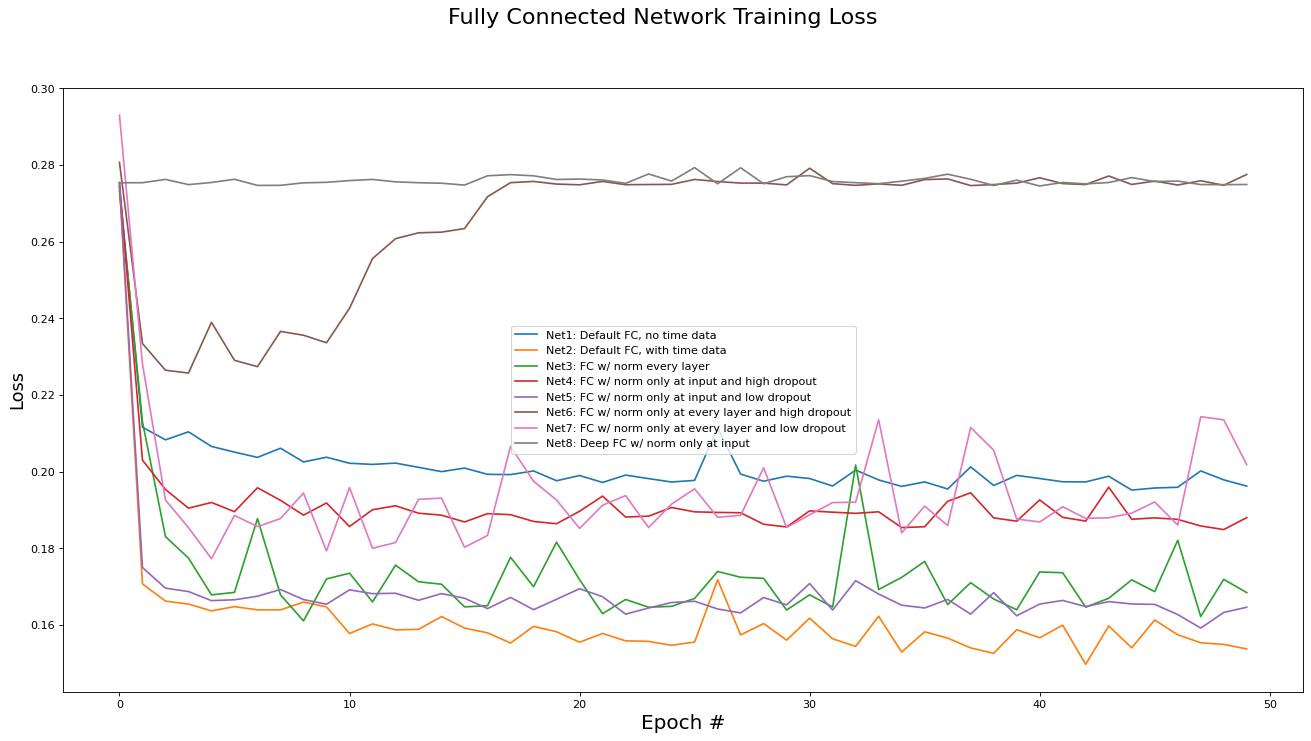

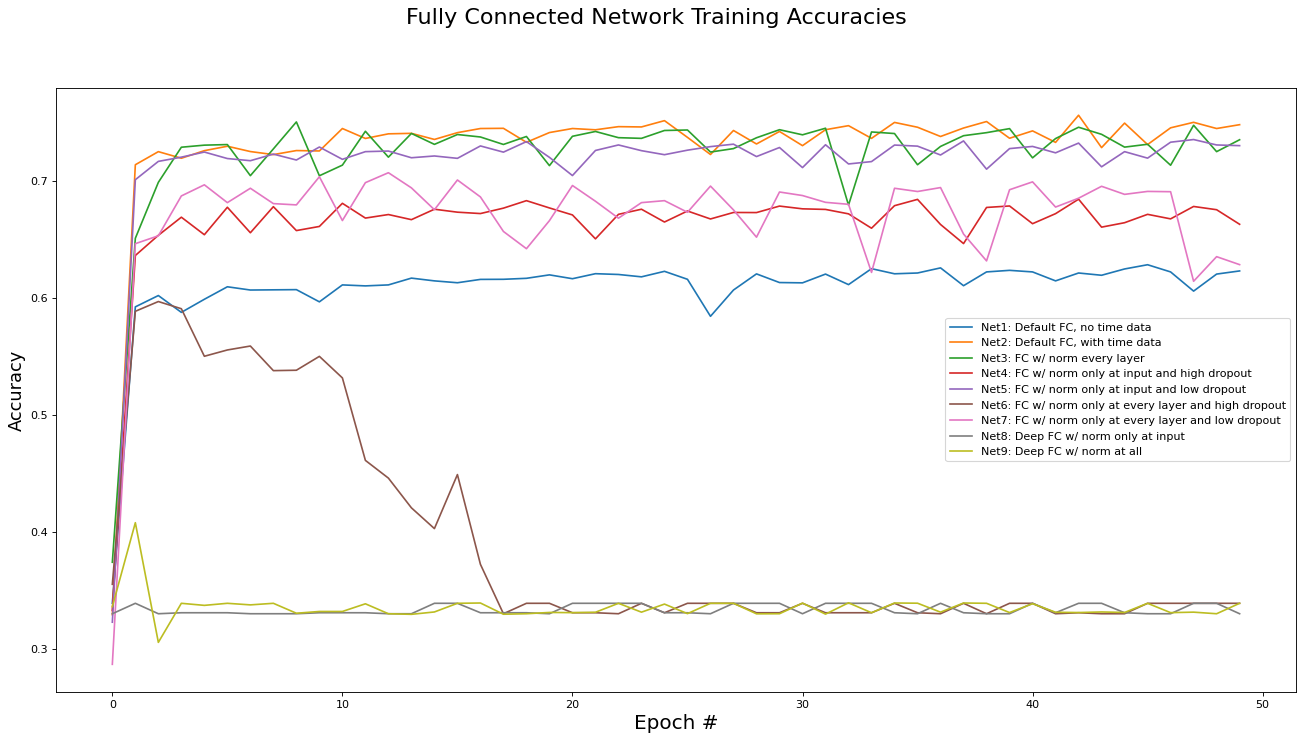

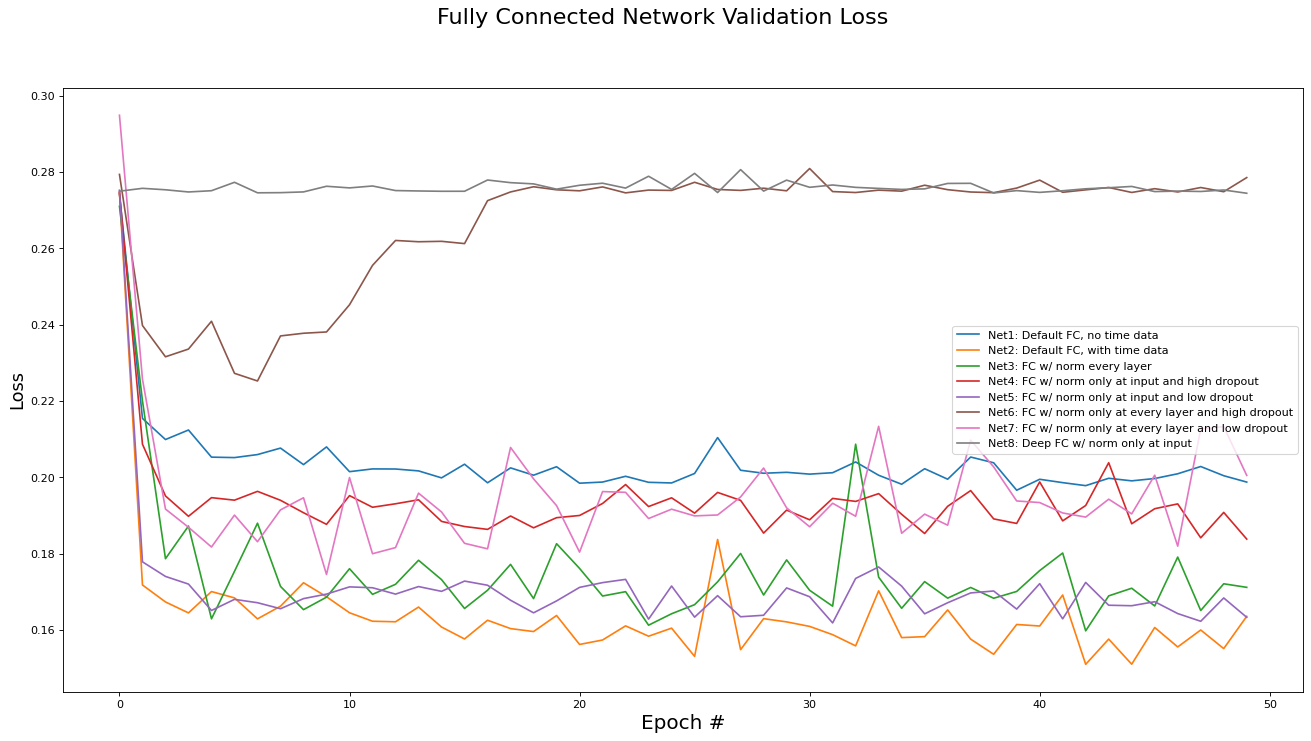

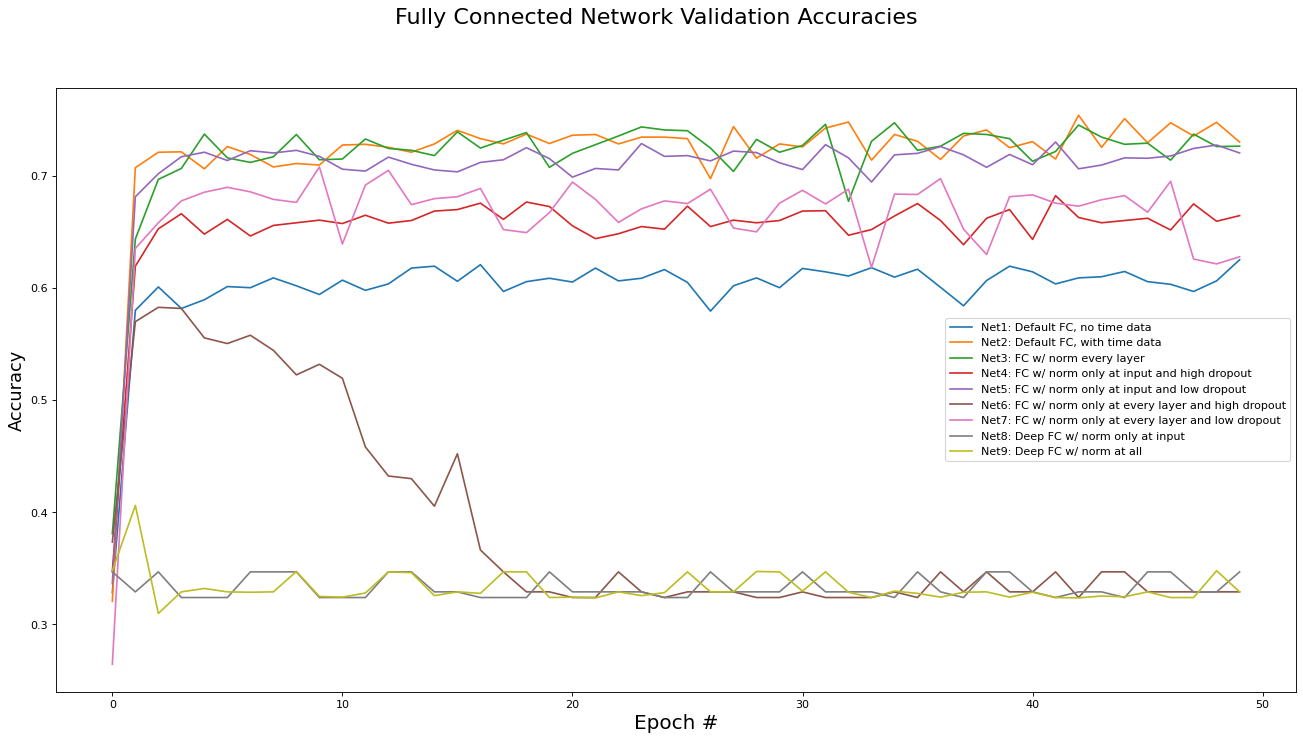

In [ ]:
fc_nets = nets[0:9]
fc_loss = nets[0:8]
fc_loss_labels = labels[0:8]
fc_labels = labels[0:9]
plot_nets(fc_loss, fc_loss_labels, 0, "Fully Connected Network Training Loss", "Loss")
plot_nets(fc_nets, fc_labels, 1, "Fully Connected Network Training Accuracies", "Accuracy")
plot_nets(fc_loss, fc_loss_labels, 2, "Fully Connected Network Validation Loss", "Loss")
plot_nets(fc_nets, fc_labels, 3, "Fully Connected Network Validation Accuracies", "Accuracy")
print_bests("Fully Connected", fc_nets, fc_labels)
best_fc_net_i = 1

Best Residual network for Training Loss is 'Net10: Shallow ResNet' with metric of 0.15598115658645756 at epoch# 26
Best Residual network for Training Accs is 'Net10: Shallow ResNet' with metric of 0.7447005383580081 at epoch# 46
Best Residual network for Validate Loss is 'Net10: Shallow ResNet' with metric of 0.1543440181601537 at epoch# 27
Best Residual network for Validate Accs is 'Net10: Shallow ResNet' with metric of 0.7506729475100942 at epoch# 27


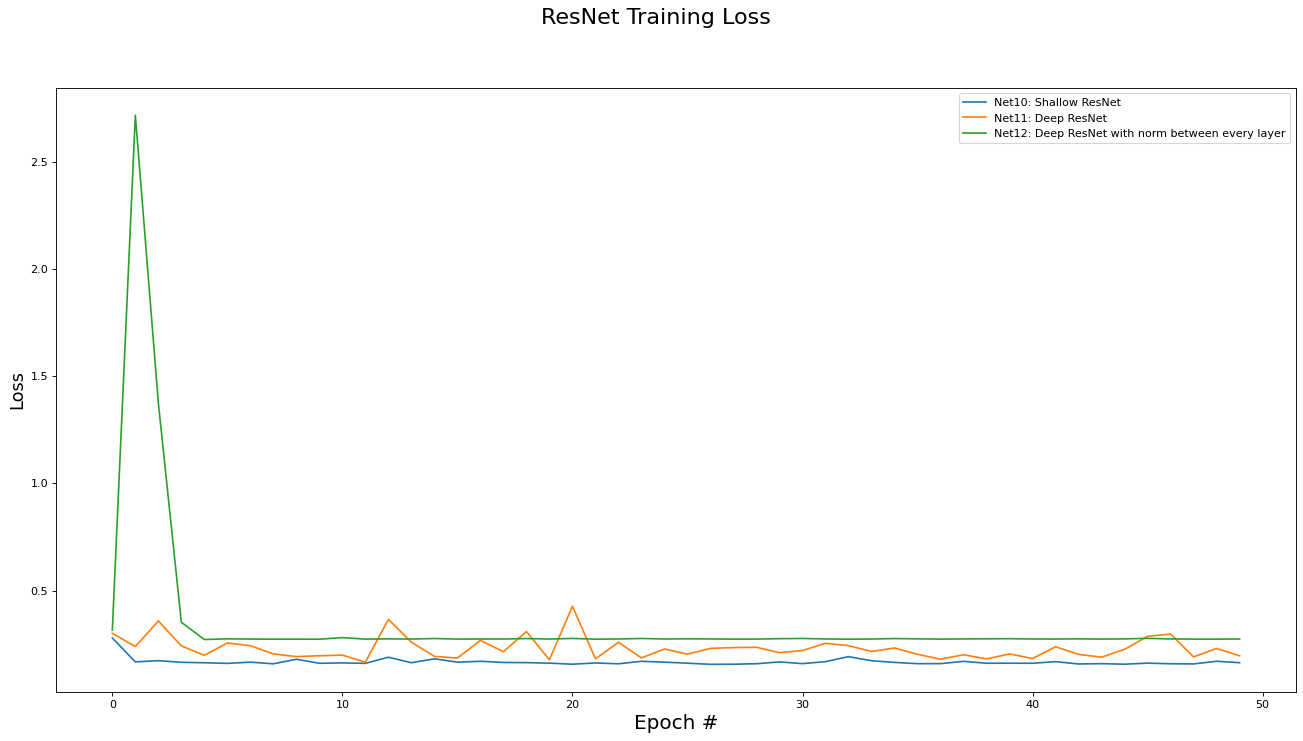

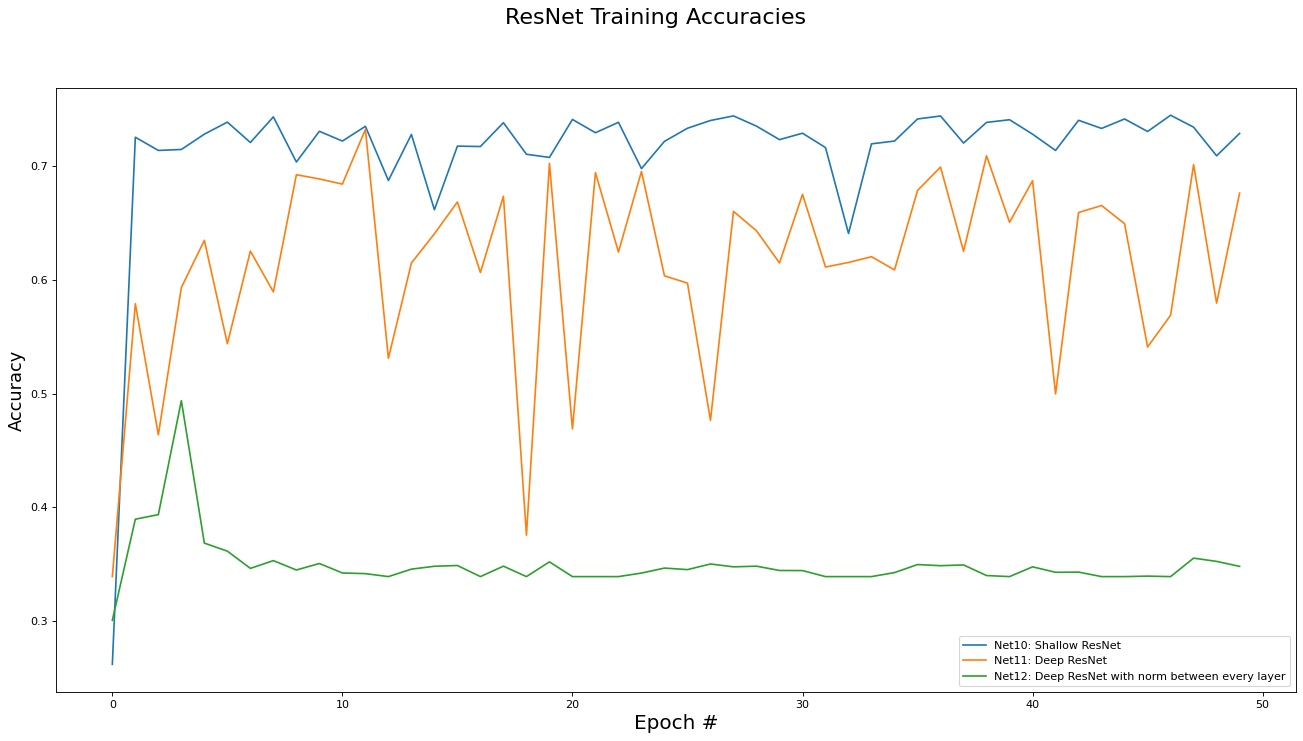

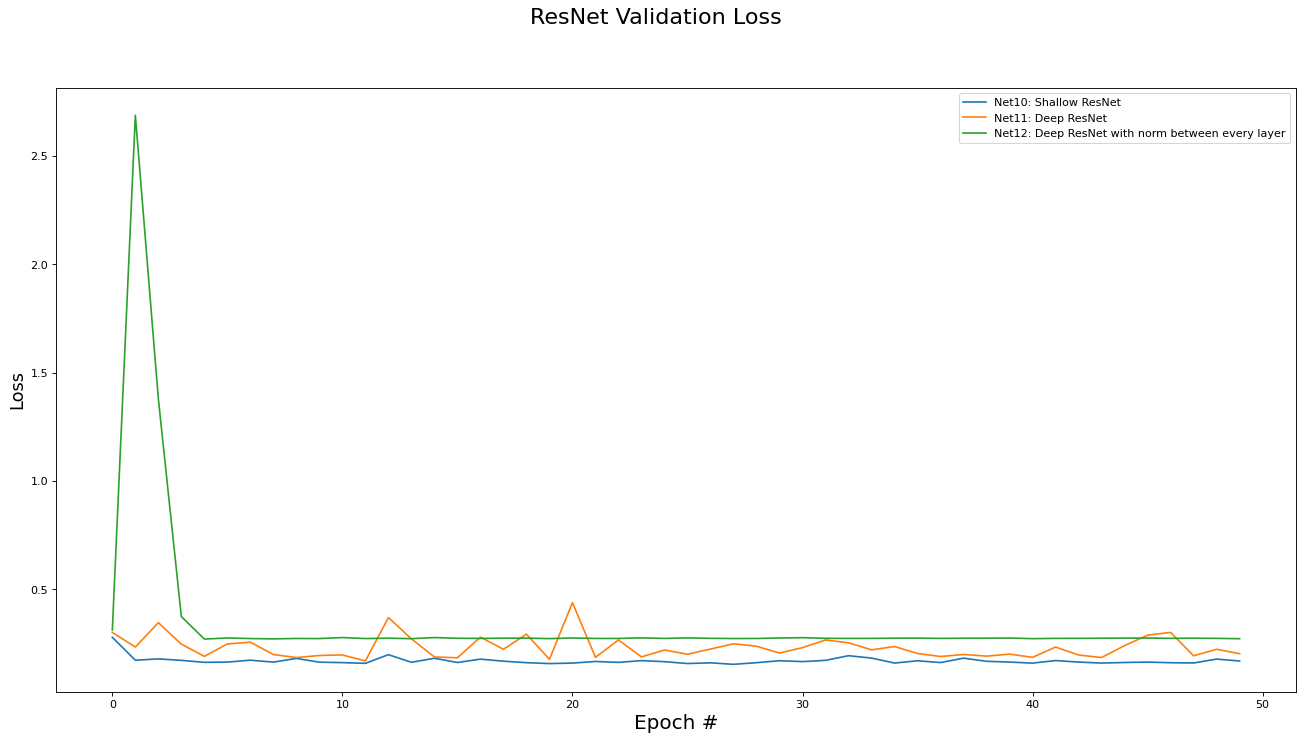

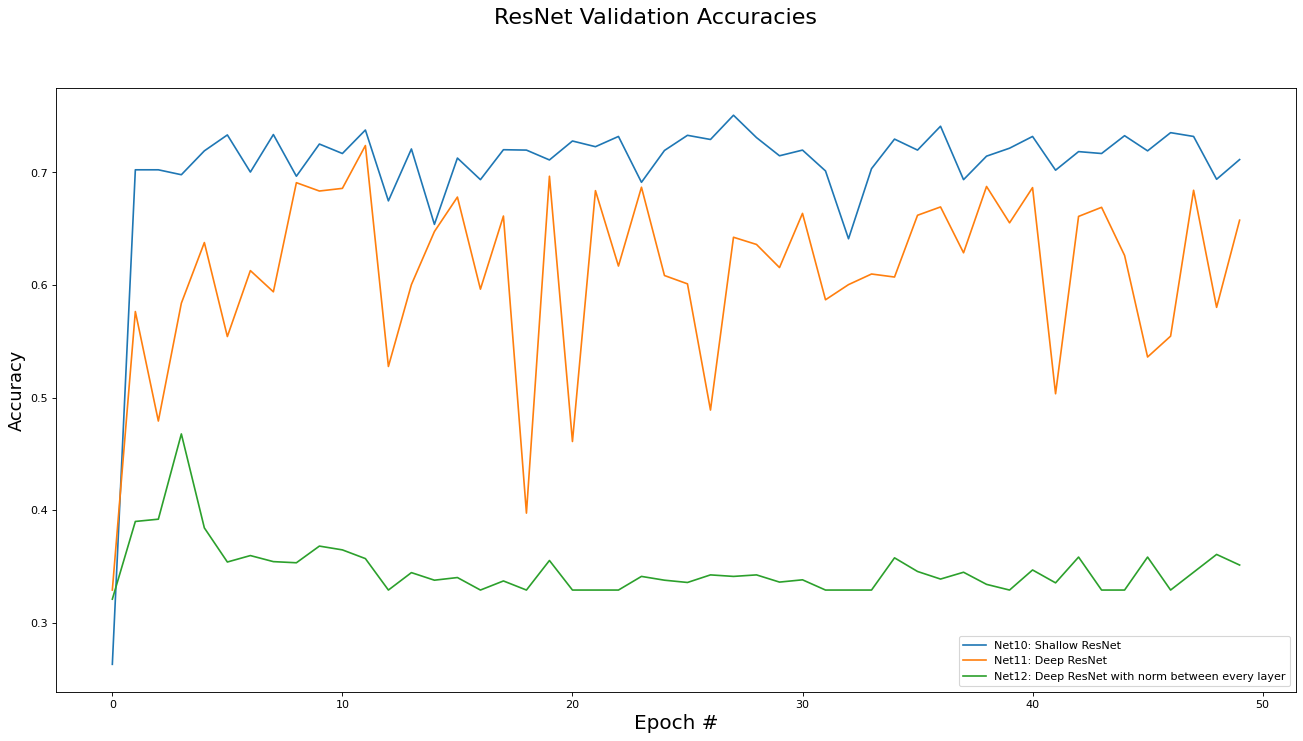

In [ ]:
res_nets = nets[9:12]
res_labels = labels[9:12]
plot_nets(res_nets, res_labels, 0, "ResNet Training Loss", "Loss")
plot_nets(res_nets, res_labels, 1, "ResNet Training Accuracies", "Accuracy")
plot_nets(res_nets, res_labels, 2, "ResNet Validation Loss", "Loss")
plot_nets(res_nets, res_labels, 3, "ResNet Validation Accuracies", "Accuracy")
print_bests("Residual", res_nets, res_labels)
best_res_i = 9

Best RNN network for Training Loss is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.00031146926001644136 at epoch# 199
Best RNN network for Training Accs is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.9214267687389586 at epoch# 199
Best RNN network for Validate Loss is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.006466919979930406 at epoch# 24
Best RNN network for Validate Accs is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.8495962314939435 at epoch# 173


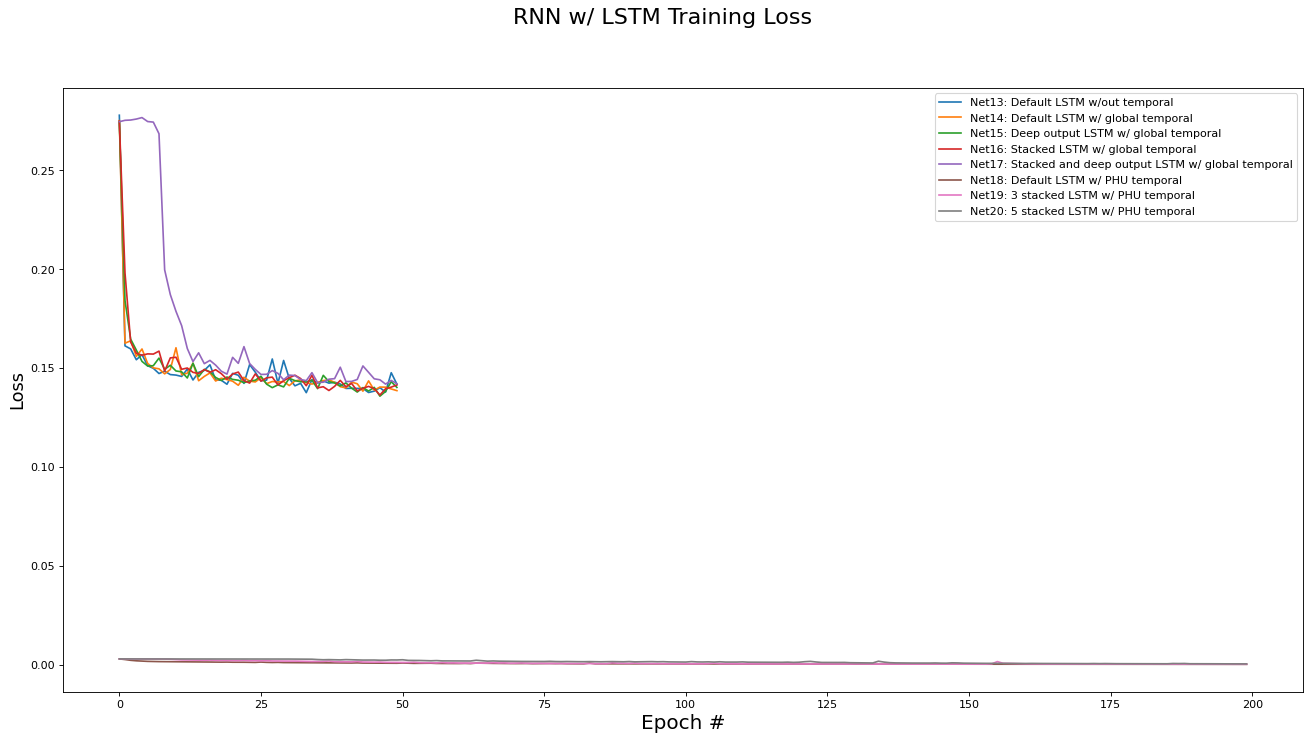

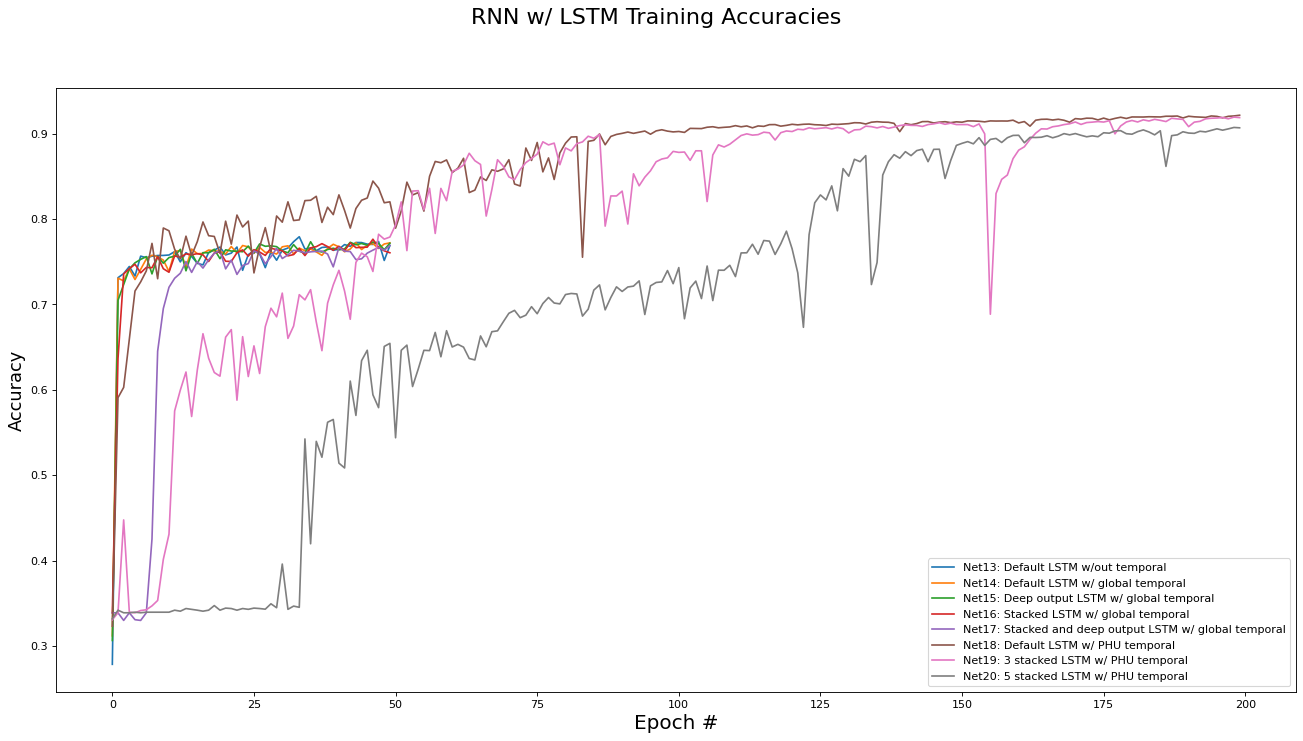

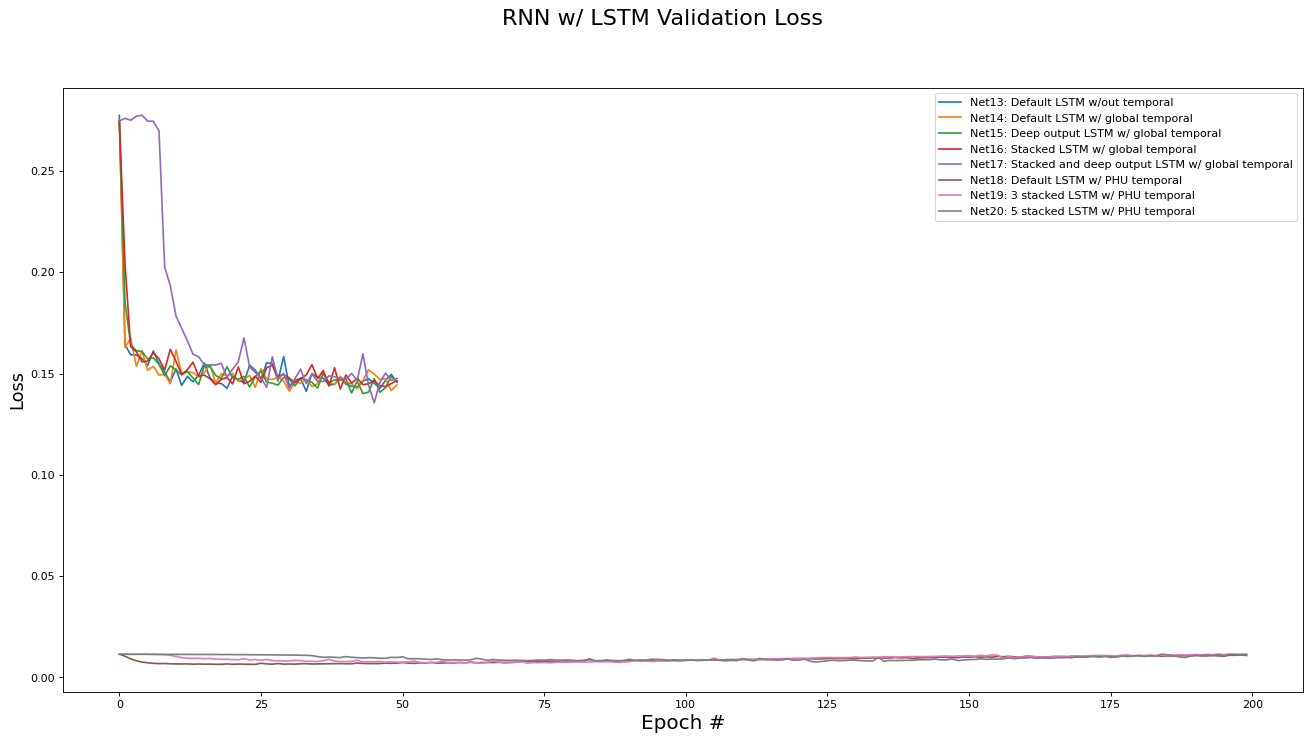

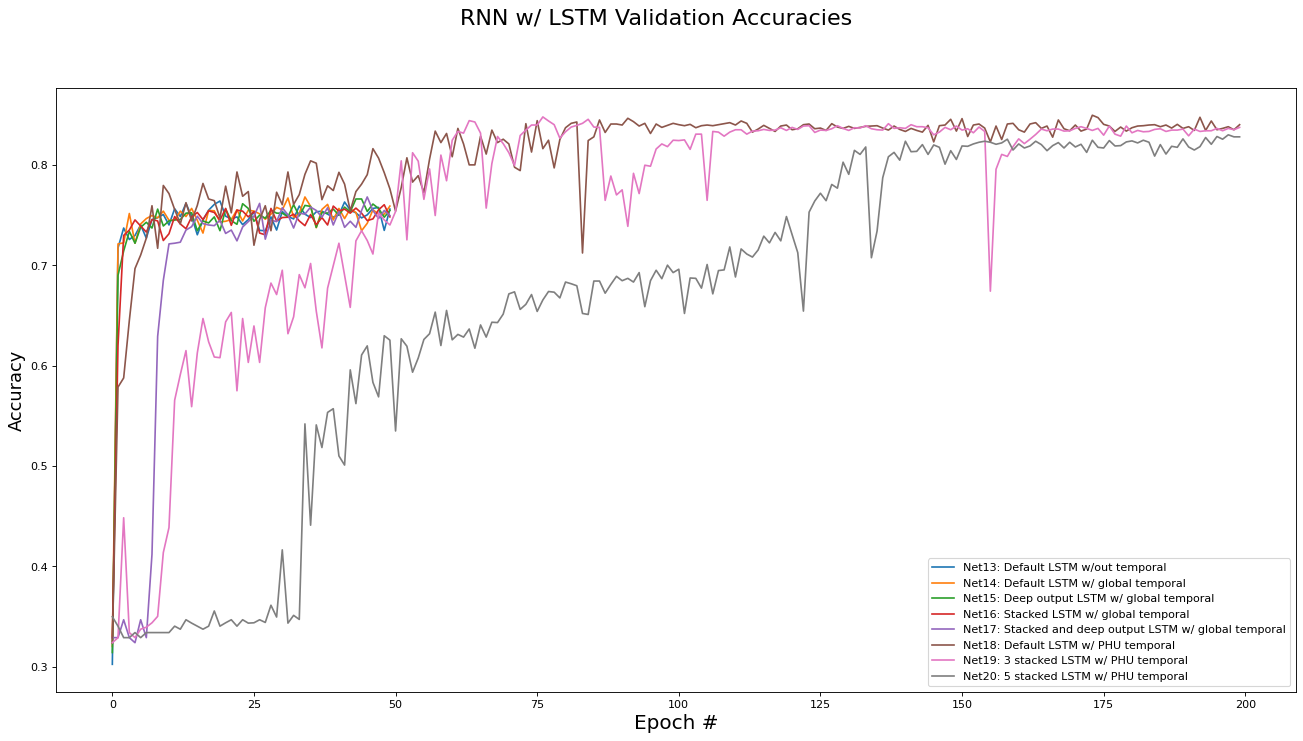

In [ ]:
rnn_nets = nets[12:20]
rnn_labels = labels[12:20]
plot_nets(rnn_nets, rnn_labels, 0, "RNN w/ LSTM Training Loss", "Loss")
plot_nets(rnn_nets, rnn_labels, 1, "RNN w/ LSTM Training Accuracies", "Accuracy")
plot_nets(rnn_nets, rnn_labels, 2, "RNN w/ LSTM Validation Loss", "Loss")
plot_nets(rnn_nets, rnn_labels, 3, "RNN w/ LSTM Validation Accuracies", "Accuracy")
print_bests("RNN", rnn_nets, rnn_labels)
best_rnn_i = 17

Best FC vs. ResNet vs. RNN w/ LSTM network for Training Loss is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.00031146926001644136 at epoch# 199
Best FC vs. ResNet vs. RNN w/ LSTM network for Training Accs is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.9214267687389586 at epoch# 199
Best FC vs. ResNet vs. RNN w/ LSTM network for Validate Loss is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.006466919979930406 at epoch# 24
Best FC vs. ResNet vs. RNN w/ LSTM network for Validate Accs is 'Net18: Default LSTM w/ PHU temporal' with metric of 0.8495962314939435 at epoch# 173


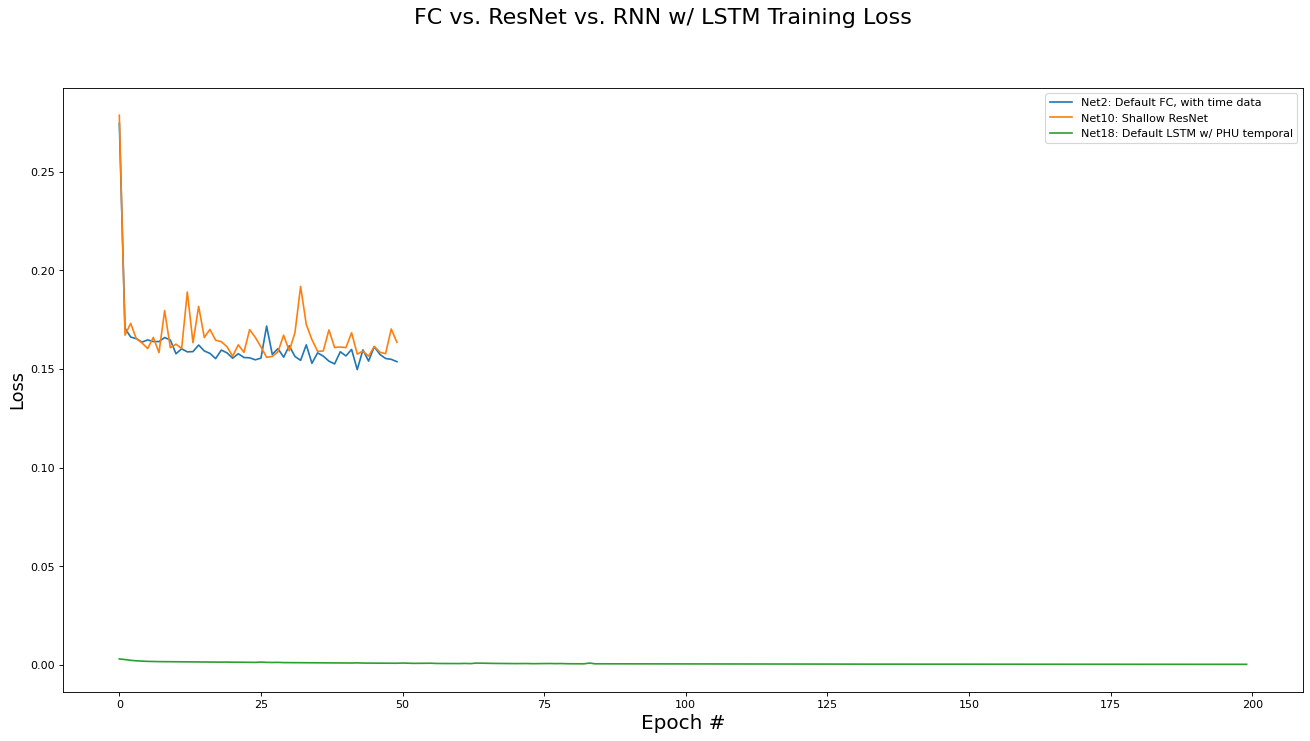

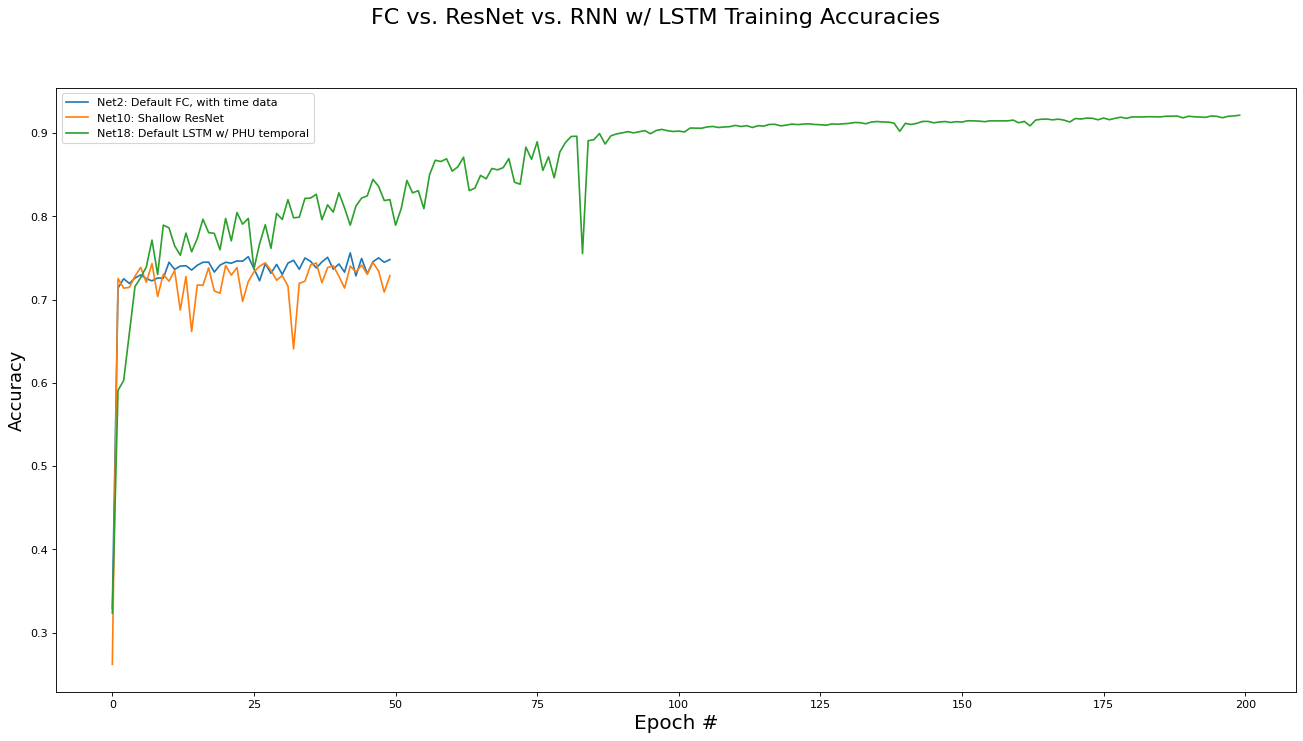

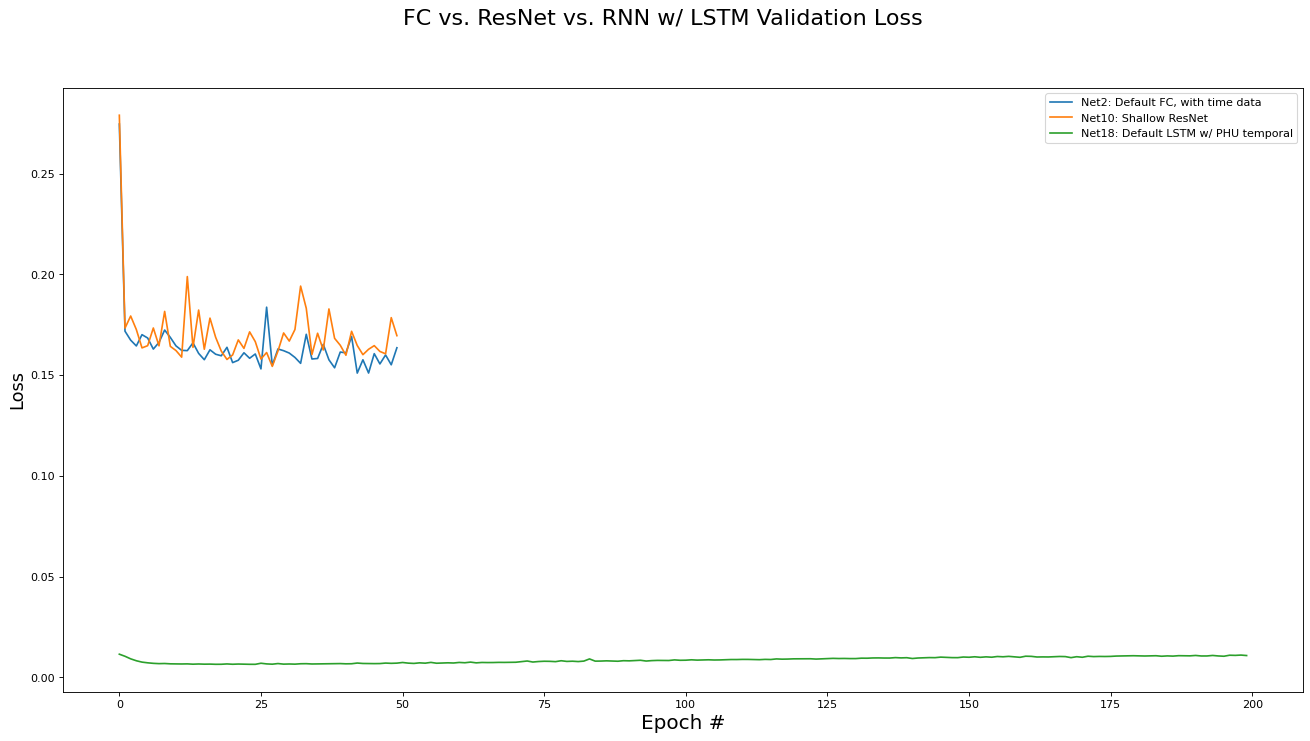

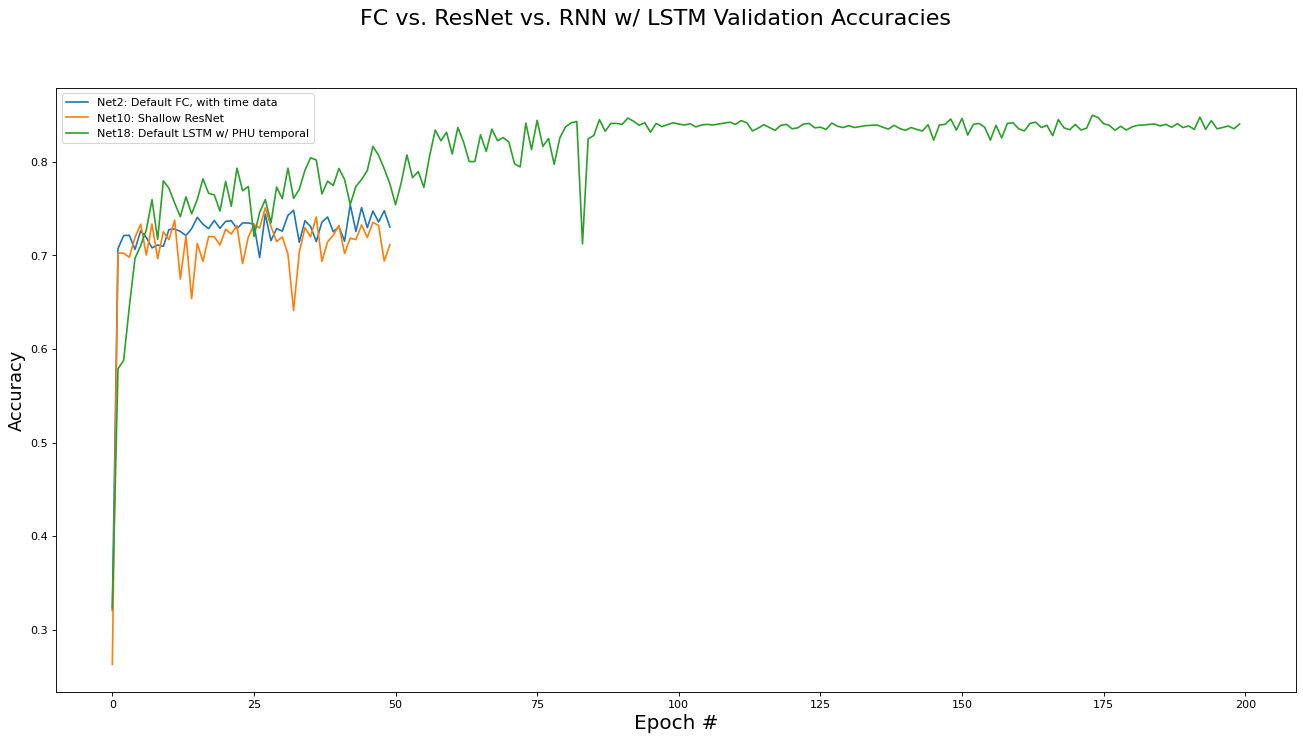

In [ ]:
compare_nets = [nets[best_fc_net_i]] + [nets[best_res_i]] + [nets[best_rnn_i]]
compare_labels = [labels[best_fc_net_i]] + [labels[best_res_i]] + [labels[best_rnn_i]]
plot_nets(compare_nets, compare_labels, 0, "FC vs. ResNet vs. RNN w/ LSTM Training Loss", "Loss")
plot_nets(compare_nets, compare_labels, 1, "FC vs. ResNet vs. RNN w/ LSTM Training Accuracies", "Accuracy")
plot_nets(compare_nets, compare_labels, 2, "FC vs. ResNet vs. RNN w/ LSTM Validation Loss", "Loss")
plot_nets(compare_nets, compare_labels, 3, "FC vs. ResNet vs. RNN w/ LSTM Validation Accuracies", "Accuracy")
print_bests("FC vs. ResNet vs. RNN w/ LSTM", compare_nets, compare_labels)